# Exercise

<b>Note: The Exercises in this tutorial are for your practice only. They will not be graded.</b>

> **Colab is strongly Recommended for this tutorial exercise!**

<a href="https://colab.research.google.com/github/yunmeng-genius/T7_Pytorch/blob/master/Tutorial%207%20Exercise%20Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Multi-class Classification Problem

**Dataset**: Make a multi-class classification dataset with [CS231n](https://cs231n.github.io/neural-networks-case-study/).

- For consistency, the dataset should have 10000 samples and a `random_state=42` (keeps the same in the whole notebook exercises).

**RUN BELOW CODES!**


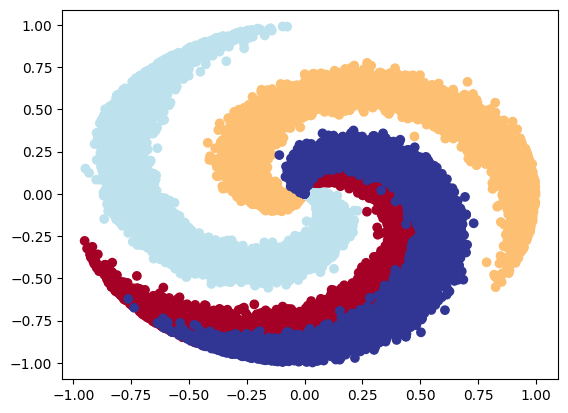

In [233]:
import pandas as pd
import numpy as np


RANDOM_SEED = 42


np.random.seed(RANDOM_SEED)
N = 10000  # number of points per class
D = 2  # dimensionality
K = 4  # number of classes
X = np.zeros((N * K, D))  # data matrix (each row = single example)
y = np.zeros(N * K, dtype="uint8")  # class labels
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

**Q1: Data Preprocessing**

- Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

- Create a DataLoader for the training and test sets using `torch.utils.data.DataLoader` and `torch.utils.data.TensorDataset`. Set the batch size to 128.


In [234]:
# Create a dataset and dataloader
import torch

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)


train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

**Q2: Model Construction**

Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
You might build the model using below structure:

- Input layer
- One hidden layer with 32 neurons and ReLU activation function
- One hidden layer with 16 neurons and ReLU activation function
- One output layer with 4 neurons (since we have 4 classes) and softmax activation function (it has been combined with the loss function in PyTorch so we don't need to specify it separately).

* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.


In [235]:
import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(2, 32)
        self.hidden_layer1 = nn.Linear(32, 16) 
        self.hidden_layer2 = nn.Linear(16, 4)  # this is the output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.hidden_layer2(x)
        return x

model = MyModel()

In [236]:
print(model)

MyModel(
  (input_layer): Linear(in_features=2, out_features=32, bias=True)
  (hidden_layer1): Linear(in_features=32, out_features=16, bias=True)
  (hidden_layer2): Linear(in_features=16, out_features=4, bias=True)
  (relu): ReLU()
)


**Q3: Loss Function and Optimizer**

Define a loss function and an optimizer for the model you built in 2. Use `CrossEntropyLoss` as the loss function and `SGD` as the optimizer (set `learning rate` as `0.01`).


In [237]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**Q4: Training Loop**

- Train the model using the batches you created in 4.
- Use the model you built in 2
- Use the loss function and the optimizer you defined in 3.
- Train the model for 100 epochs.
- Print the loss of the model for every 10 epochs.


In [238]:
def train_model(model, optimizer, train_loader, loss_func, num_epochs, device=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            preds = model(batch_data)
            loss = loss_func(preds, batch_labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_data.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [239]:
train_model(model, optimizer, train_loader, loss_func, num_epochs=100)

Epoch 10/100, Loss: 0.9867
Epoch 20/100, Loss: 0.8066
Epoch 30/100, Loss: 0.5987
Epoch 40/100, Loss: 0.4607
Epoch 50/100, Loss: 0.3654
Epoch 60/100, Loss: 0.2999
Epoch 70/100, Loss: 0.2557
Epoch 80/100, Loss: 0.2264
Epoch 90/100, Loss: 0.2057
Epoch 100/100, Loss: 0.1904


**Q5: Evaluation**

- Evaluate the model on the test set.
- Calculate the accuracy of the model on the test set.


In [241]:
def eval_model(model, test_loader, device=None):
    device = device or torch.device(
        "cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    correct_preds, total_preds = 0, 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(
                device), batch_labels.to(device)
            preds = model(batch_data)
            _, pred_labels = torch.max(preds, 1)
            correct_preds += (pred_labels == batch_labels).sum().item()
            total_preds += batch_labels.size(0)

    acc = correct_preds / total_preds
    print(f"Accuracy of the model: {acc * 100:.2f}%")

eval_model(model, test_loader)

Accuracy of the model: 94.24%


**You can also try other artifacts to achieve better erformance on this task.**